In [52]:
#load requiered libraries
library(tidyverse)
library(ggplot2)
library(dplyr)
library(caret)
library(GGally)
library(pROC)

options(
  digits = 2,
  scipen = 999
)

<font size = 6> Form Step 1: Data Cleaning <font>

https://archive.ics.uci.edu/dataset/938/regensburg+pediatric+appendicitis

This repository holds the data from a cohort of **pediatric patients with suspected appendicitis admitted with abdominal pain to Children’s Hospital St. Hedwig in Regensburg, Germany, between 2016 and 2021**. <br>

Each patient has (potentially multiple) ultrasound (US) images, aka views, tabular data comprising laboratory, physical examination, scoring results and ultrasonographic findings extracted manually by the experts, and three target variables, namely, diagnosis, management and severity. <br>

This data has 782 rows and 58 columns. There is a combination of binary, categorical, integer and continuous predictor columns. <br>

From column 25 onwards there are multiple columns with na values majorly. These columns are also very specialized and we might not be able to interprete them as good as the other columns. Therefore we will make a selection of the features that are good candidates for our model based on the number of NA values and colinearity.

In [2]:
#Load raw data
df <-  readxl::read_excel("C:\\Users\\minaa\\Desktop\\Statistics\\Spring 2024\\STA 6714\\Term Project\\app_data.xlsx") %>% data.frame()
head(df)
dim(df)

,Age,BMI,Sex,Height,Weight,Length_of_Stay,Management,Severity,Diagnosis_Presumptive,Diagnosis,⋯,Abscess_Location,Pathological_Lymph_Nodes,Lymph_Nodes_Location,Bowel_Wall_Thickening,Conglomerate_of_Bowel_Loops,Ileus,Coprostasis,Meteorism,Enteritis,Gynecological_Findings
,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,13,16.899999999999999,female,148,37,3,conservative,uncomplicated,appendicitis,appendicitis,⋯,NA,yes,reUB,NA,NA,NA,NA,NA,NA,NA
2,14,31.9,male,147,70,2,conservative,uncomplicated,appendicitis,no appendicitis,⋯,NA,NA,NA,NA,NA,NA,NA,yes,NA,NA
3,14,23.3,female,163,62,4,conservative,uncomplicated,appendicitis,no appendicitis,⋯,NA,NA,NA,NA,NA,NA,NA,yes,yes,NA
4,16,20.6,female,165,56,3,conservative,uncomplicated,appendicitis,no appendicitis,⋯,NA,yes,reUB,NA,NA,NA,NA,NA,yes,NA
5,11,16.899999999999999,female,163,45,3,conservative,uncomplicated,appendicitis,appendicitis,⋯,NA,yes,reUB,NA,NA,NA,NA,NA,yes,NA
6,11,30.7,male,121,45,3,conservative,uncomplicated,appendicitis,no appendicitis,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


[1] 782  58

<font size = 5> Remove Null and irrelavant columns <font>

In [3]:
#What percentage of each column is NULL value?
NA_percentage <- df %>%
  summarise_all(~mean(is.na(.)) * 100) %>%
  mutate_all(.funs = ~round(., digits = 2))

#Only keep columns with less than 20% NA values.
selected_features <- NA_percentage %>% 
                        select_if(~all(. < 20)) %>% 
                        colnames()

#Remove other two target columns and only keep "Diagnosis" as our target column. Also put the target column at the end.
selected_features <- c(selected_features[-c(7,8, 10)], selected_features[10])

df_clean <- df[,selected_features]


#Eliminate the two rows that have null values for the target column.
df_clean = df_clean[complete.cases(df_clean$Diagnosis),]


#Remove Ultra sound number, US_Performed, Diagnosis_Presumptive and drop NA values
df_clean <- df_clean %>%
            select(-US_Number, , -US_Performed, -Diagnosis_Presumptive) %>%
            drop_na()

#Convert the target values to 0 and 1
df_clean <-   df_clean %>%
              mutate(Diagnosis = as.factor(if_else(Diagnosis == "appendicitis", 1, 0))) 


<font size = 6 > Correlation and Collinearity  <font>

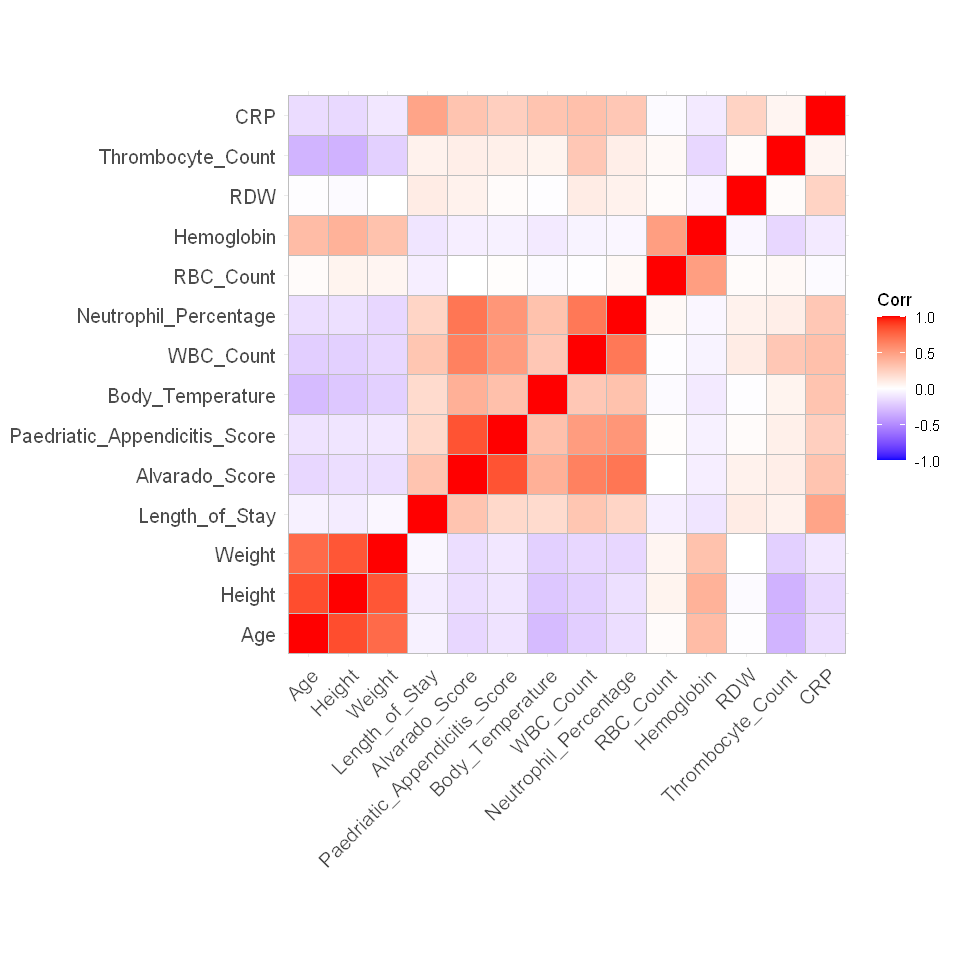

In [4]:
options(repr.plot.width = 8, repr.plot.height = 8)

#Check the correlation between the variables

df_clean %>% 
select(where(is.numeric)) %>%
cor() %>%
ggcorrplot::ggcorrplot()

Weight and Height have high correlation. We can remove **Height** without loosing much information from our data. <br>


Paedriatic_Appendicitis_Score and Alvarado_Score are highly correlated too. Let's look at their relationship with the target value and their definitions.

**Paedriatic_Appendicitis_Score:** <br>
*Definition:* It is a clinical score that helps determine the risk of appendicitis in children. A score of 6 or more makes the true case of appendicitis very likely. <br>
*Components:* Abdominal pain, Anorexia, Nausea, Fever and altered bowel habits.

**Alvarado_Score:** <br>
*Definition:* It is an older scoring system used to help diagnose appendicitis. <br>
*Components:* Nausea, Anorexia, Migration of pain, Reound pain, Elevated temperature.

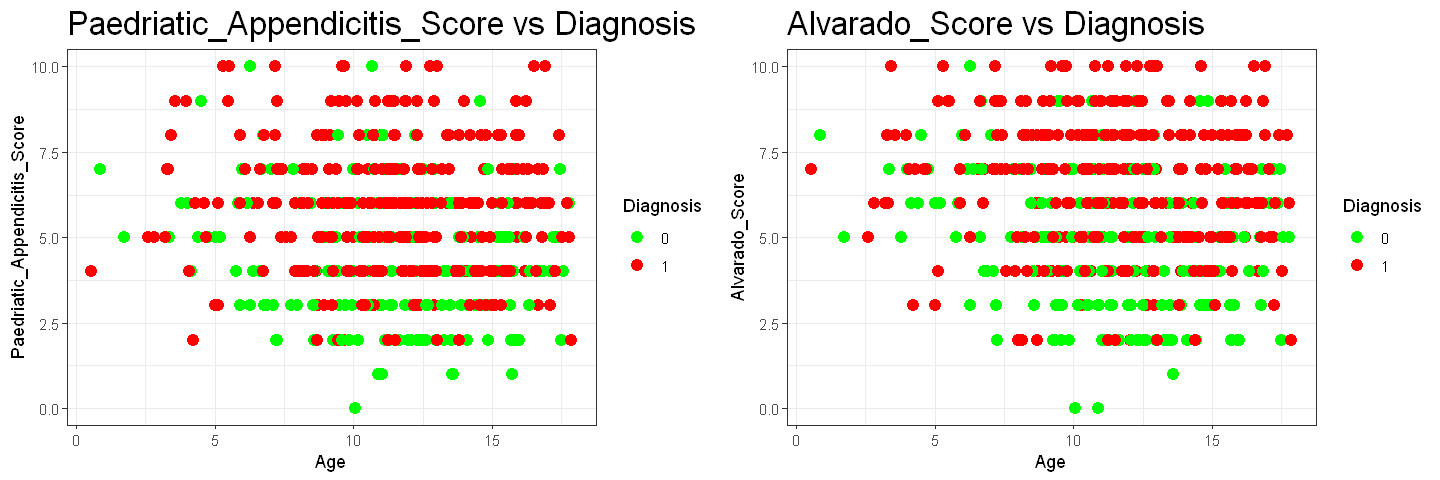

In [5]:
options(repr.plot.width = 12, repr.plot.height = 4)

#Exploring the relationship between Paedriatic_Appendicitis_Score, Alvarado_Score and the target variable
plot_1<-  ggplot(df_clean) +
            aes(x=Age, y=Paedriatic_Appendicitis_Score, color = Diagnosis) +
            geom_point(size = 3) +
            scale_color_manual(values = c("0" = "green", "1" = "red")) +
            theme_bw() +
            labs(title = "Paedriatic_Appendicitis_Score vs Diagnosis") +
            theme(plot.title = element_text(size=20))

plot_2<-  ggplot(df_clean) +
            aes(x=Age, y=Alvarado_Score, color = Diagnosis) +
            geom_point(size = 3) +
            scale_color_manual(values = c("0" = "green", "1" = "red")) +
            theme_bw() +
            labs(title = "Alvarado_Score vs Diagnosis") +
            theme(plot.title = element_text(size=20))

gridExtra::grid.arrange(plot_1, plot_2, ncol =2)

As we expected the higher the Paedriatic_Appendicitis_Score or the Alvarado_Score the higher the chance of appendicitis diagnosis. <br>
Since the components of these two scoring systems are approximately covered by the other predictors, it is better to drop these two columns and avoid any collinearity.

In [6]:
#drop columns
df_clean <- df_clean %>%
select(-Height, -Alvarado_Score, -Paedriatic_Appendicitis_Score)

In [7]:
#exploring the Appendix_on_US vs. target variable
M_plot  <-   df_clean %>% 
                            group_by(Appendix_on_US, Diagnosis) %>% 
                            summarise(count = n()) %>% 
                            mutate(percentage = round(count *100 /sum(count))) %>%
                            mutate(percentage = paste0(count, "\n", percentage, "%"))
M_plot

`summarise()` has grouped output by 'Appendix_on_US'. You can override using the `.groups` argument.


Appendix_on_US,Diagnosis,count,percentage
<chr>,<fct>,<int>,<chr>
no,0,138,138 77%
no,1,42,42 23%
yes,0,99,99 26%
yes,1,275,275 74%


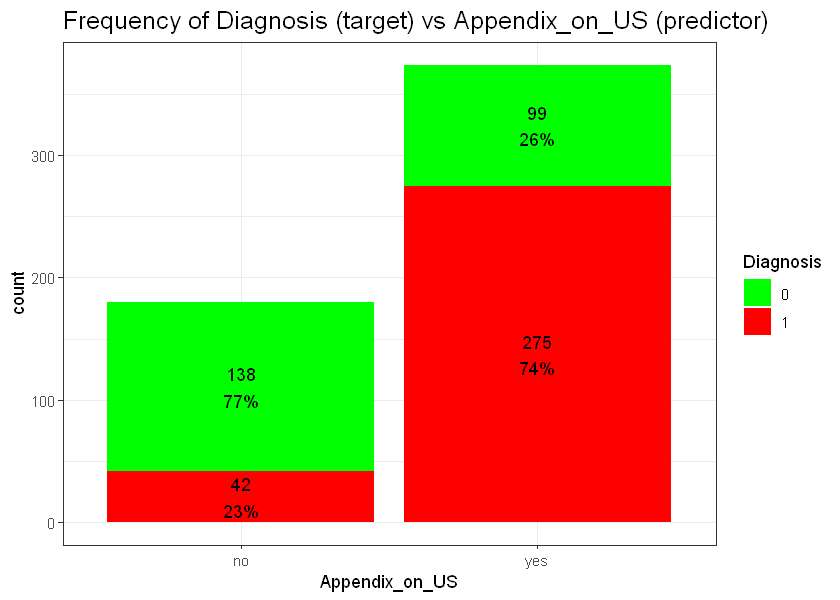

In [8]:
options(repr.plot.width = 7, repr.plot.height = 5)

#Stacked bar plot for Appendix_on_US and Diagnosis
ggplot(M_plot) +
aes(x=Appendix_on_US, y=count, fill = Diagnosis, label = percentage) +
geom_col() +
theme_bw() +
scale_fill_manual(values = c("0" = "green", "1" = "red")) +
geom_text(position = position_stack(0.5)) +
labs(title = "Frequency of Diagnosis (target) vs Appendix_on_US (predictor)") +
theme(plot.title = element_text(size=15))

**Appendix_on_US** is "Detectability of the vermiform appendix during sonographic examination" which is almost the indicator of the target value. <br>
We will not eliminate this column for now. 

In [9]:
#save the clean data for future steps
write.csv(df_clean, "C:\\Users\\minaa\\Desktop\\Statistics\\Spring 2024\\STA 6714\\Term Project\\clean_data.csv")

In [10]:
#Read in the clean data set from the 1st step
df <- read.csv("C:\\Users\\minaa\\Desktop\\Statistics\\Spring 2024\\STA 6714\\Term Project\\clean_data.csv",
               stringsAsFactors = TRUE,
               row.names = 1)

#convert Diagnosis and Appendix_on_US to factors
df  <-  df %>% 
            mutate(
                Diagnosis = as.factor(Diagnosis),
                Appendix_on_US = as.factor(Appendix_on_US)
                )

head(df)

,Age,BMI,Sex,Weight,Length_of_Stay,Appendix_on_US,Migratory_Pain,Lower_Right_Abd_Pain,Contralateral_Rebound_Tenderness,Coughing_Pain,⋯,Hemoglobin,RDW,Thrombocyte_Count,CRP,Dysuria,Stool,Peritonitis,Psoas_Sign,Free_Fluids,Diagnosis
,<dbl>,<dbl>,<fct>,<dbl>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<dbl>,<dbl>,<int>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,13,17,female,37,3,yes,no,yes,yes,no,⋯,15,12,254,0,no,normal,no,yes,no,1
2,14,32,male,70,2,no,yes,yes,yes,no,⋯,16,13,151,3,yes,normal,no,yes,no,0
3,14,23,female,62,4,no,no,yes,yes,no,⋯,11,12,300,3,no,constipation,no,yes,no,0
4,16,21,female,56,3,no,yes,yes,no,no,⋯,14,13,258,0,yes,normal,no,yes,no,0
5,11,17,female,45,3,yes,no,yes,yes,yes,⋯,13,14,311,0,no,constipation,no,yes,no,1
6,11,31,male,45,3,no,yes,yes,yes,yes,⋯,12,13,249,63,no,diarrhea,no,yes,no,0


<font size = 6> Data Exploratory Analysis <font>

<font size = 5> Explore numerical predictors <font>

In [11]:
summary(df %>% select(where(is.numeric)))

      Age            BMI         Weight    Length_of_Stay Body_Temperature
 Min.   : 0.5   Min.   : 8   Min.   : 12   Min.   : 1     Min.   :27      
 1st Qu.: 9.4   1st Qu.:16   1st Qu.: 31   1st Qu.: 3     1st Qu.:37      
 Median :11.5   Median :18   Median : 42   Median : 3     Median :37      
 Mean   :11.5   Mean   :19   Mean   : 44   Mean   : 4     Mean   :37      
 3rd Qu.:14.2   3rd Qu.:21   3rd Qu.: 55   3rd Qu.: 4     3rd Qu.:38      
 Max.   :17.9   Max.   :38   Max.   :103   Max.   :28     Max.   :40      
   WBC_Count  Neutrophil_Percentage   RBC_Count      Hemoglobin        RDW    
 Min.   : 4   Min.   :27            Min.   : 3.6   Min.   : 8.2   Min.   :11  
 1st Qu.: 8   1st Qu.:60            1st Qu.: 4.6   1st Qu.:12.7   1st Qu.:12  
 Median :12   Median :74            Median : 4.8   Median :13.4   Median :13  
 Mean   :12   Mean   :71            Mean   : 4.8   Mean   :13.4   Mean   :13  
 3rd Qu.:16   3rd Qu.:83            3rd Qu.: 5.0   3rd Qu.:14.0   3rd Qu.:13  
 

<font size =5> Handeling Outliers <font>

In [12]:
df %>% filter(Body_Temperature <30)  %>% select(1:20)

Age,BMI,Sex,Weight,Length_of_Stay,Appendix_on_US,Migratory_Pain,Lower_Right_Abd_Pain,Contralateral_Rebound_Tenderness,Coughing_Pain,Nausea,Loss_of_Appetite,Body_Temperature,WBC_Count,Neutrophil_Percentage,Neutrophilia,RBC_Count,Hemoglobin,RDW,Thrombocyte_Count
<dbl>,<dbl>,<fct>,<dbl>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<int>
17,18,female,48,3,no,no,yes,no,no,no,no,27,5.8,63,no,4.4,14,12,205


There is a case with the **Body_Temperature** of 27 Celcius Degree. This amount is life threatening and since this is the only case with such a low amount, it could be a typo. We will adjust it to 37.

In [13]:
#Adjust the outlier for Body_Temperature
df <- df %>% 
            mutate(Body_Temperature = ifelse(Body_Temperature <30, 37, Body_Temperature)
                  )

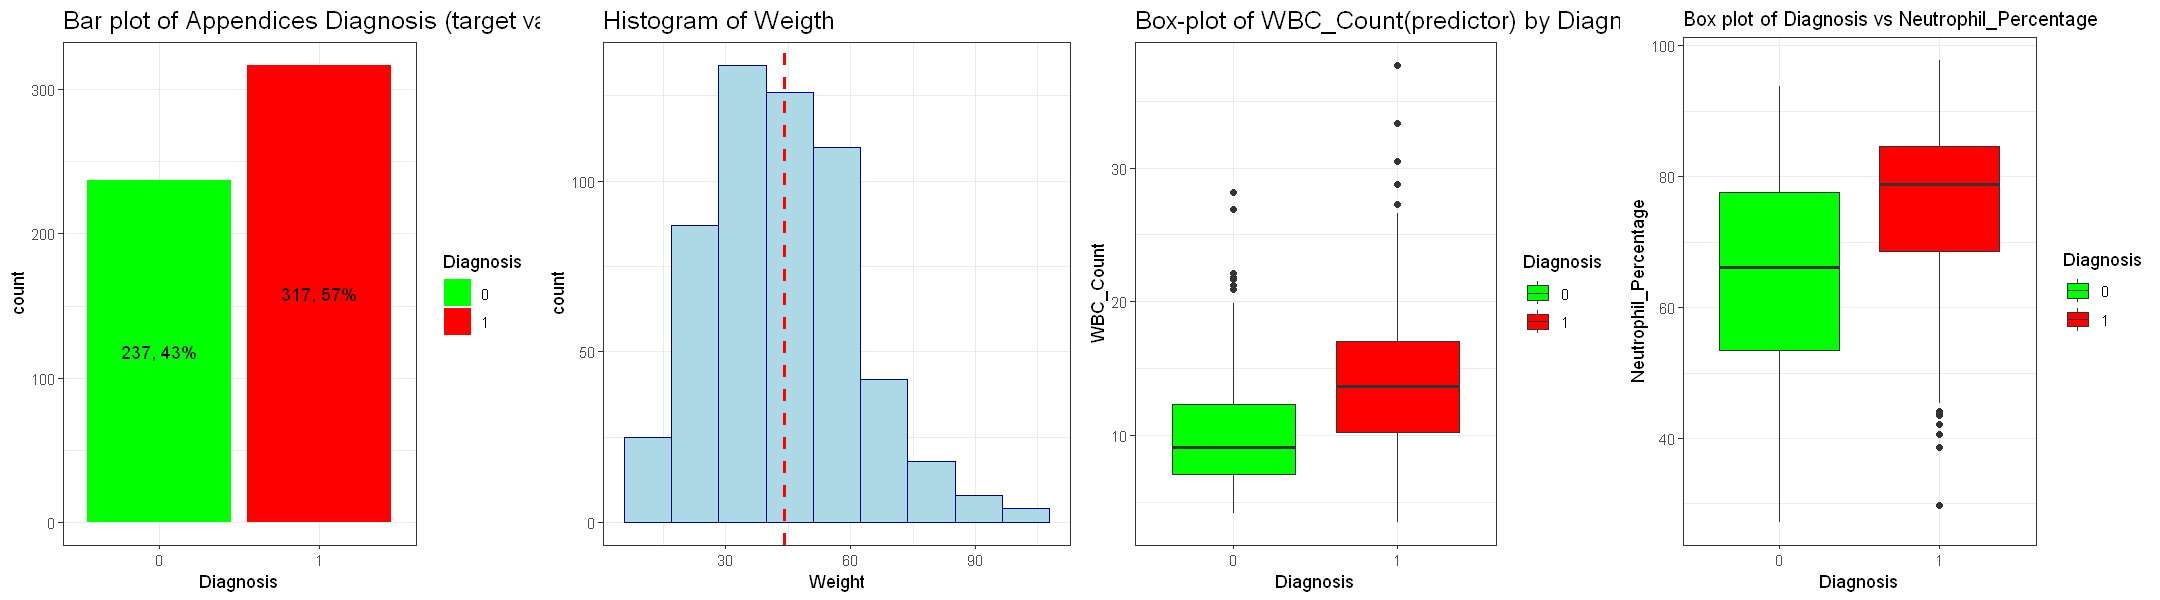

In [14]:
options(repr.plot.width = 18, repr.plot.heigth = 10)

#Average of Weight column
avg_mean = mean(na.omit(df_clean$Weight))

M_plot <- df %>%
        group_by(Diagnosis) %>%
        summarise(count = n()) %>%
        mutate(percentage = count * 100 / sum(count),
               label = paste0(count, ", ", round(percentage), "%"))

#Diagnsis Barplot
plot1 <-     ggplot(M_plot) +
                aes(x=Diagnosis, y=count, label=label, fill=Diagnosis) +
                geom_col() +
                geom_text(position = position_stack(0.5)) +
                scale_fill_manual(values = c("green", "red")) +
                theme_bw() +
                labs(title = "Bar plot of Appendices Diagnosis (target variable)") +
                theme(plot.title = element_text(size=15))


#Weight Histogram
plot2   <-     ggplot(df) +
                aes(x = Weight) +
                theme_bw() +
                geom_histogram(bins = 9, color = "darkblue", fill = "lightblue") +
                geom_vline(xintercept=avg_mean, color = "red", linetype = "dashed", linewidth = 1) +
                labs(title = "Histogram of Weigth") +
                theme(plot.title = element_text(size=15))


#WBC_Count Box plot vs Diagnosis
plot3 <-   ggplot(df) + 
                  aes(x = Diagnosis,y = WBC_Count, fill = Diagnosis) +
                  geom_boxplot() + 
                  theme_bw() + 
                  labs(title = "Box-plot of WBC_Count(predictor) by Diagnosis(target)") +
                  scale_fill_manual(values = c("0" = "green", "1" = "red"))+
                  theme(plot.title = element_text(size=15))

#Box plot of Diagnosis vs Neutrophil_Percentage
plot4 <-   ggplot(df) +
                aes(x=Diagnosis, y=Neutrophil_Percentage , fill=Diagnosis) +
                scale_fill_manual(values=c("green", "red")) +
                geom_boxplot() +
                theme_bw() +
                labs(title = "Box plot of Diagnosis vs Neutrophil_Percentage") +
                theme(plot.title = element_text(size=12))


gridExtra::grid.arrange(plot1, plot2, plot3, plot4, ncol = 4)

We see that our data is not imbalanced and it has enough data points for each class. <br>
The weight variable has an approximately normal distribution with average around 40. Note that the weigth is in kg and not lb. <br>
Positive cases of Appendicitus have a higher interquartile range and median for WBC_Count, this difference in the distribution shows us that WBC_Count could be an appropriate predictor. The same argument holds for Box plot of Diagnosis vs Neutrophil_Percentage.

<font size = 5> Explore categorical predictors <font>

In [15]:
#check different categories of the predictors
df %>% select(!where(is.numeric)) %>% lapply(unique) 

$Sex
[1] female male  
Levels: female male

$Appendix_on_US
[1] yes no 
Levels: no yes

$Migratory_Pain
[1] no  yes
Levels: no yes

$Lower_Right_Abd_Pain
[1] yes no 
Levels: no yes

$Contralateral_Rebound_Tenderness
[1] yes no 
Levels: no yes

$Coughing_Pain
[1] no  yes
Levels: no yes

$Nausea
[1] no  yes
Levels: no yes

$Loss_of_Appetite
[1] yes no 
Levels: no yes

$Neutrophilia
[1] no  yes
Levels: no yes

$Dysuria
[1] no  yes
Levels: no yes

$Stool
[1] normal                 constipation           diarrhea              
[4] constipation, diarrhea
Levels: constipation constipation, diarrhea diarrhea normal

$Peritonitis
[1] no          local       generalized
Levels: generalized local no

$Psoas_Sign
[1] yes no 
Levels: no yes

$Free_Fluids
[1] no  yes
Levels: no yes

$Diagnosis
[1] 1 0
Levels: 0 1

In [16]:
#categories of predictor "Stool"
table(df$Stool)

#merge the only data point in which Stool = "constipation, diarrhea" to "diarrhea" category which has a higher frequency compared to "constipation"
df <- df %>% mutate(Stool = if_else(Stool == "constipation, diarrhea", "diarrhea", Stool))


          constipation constipation, diarrhea               diarrhea 
                    70                      1                     80 
                normal 
                   403 

In [17]:
#frequency of Diagnosis 0 and 1 in each category of Stool
M_plot <-  df %>% 
                 group_by(
                           Stool, Diagnosis
                          ) %>%
                  summarise(
                           count = n()
                           ) %>%
                  mutate(
                         percentage = count*100 / sum(count)
                        ) %>%
                  mutate(
                         percentage = paste0(count, "\n", round(percentage), "%")
                        )
M_plot

`summarise()` has grouped output by 'Stool'. You can override using the `.groups` argument.


Stool,Diagnosis,count,percentage
<chr>,<fct>,<int>,<chr>
constipation,0,28,28 40%
constipation,1,42,42 60%
diarrhea,0,30,30 37%
diarrhea,1,51,51 63%
normal,0,179,179 44%
normal,1,224,224 56%


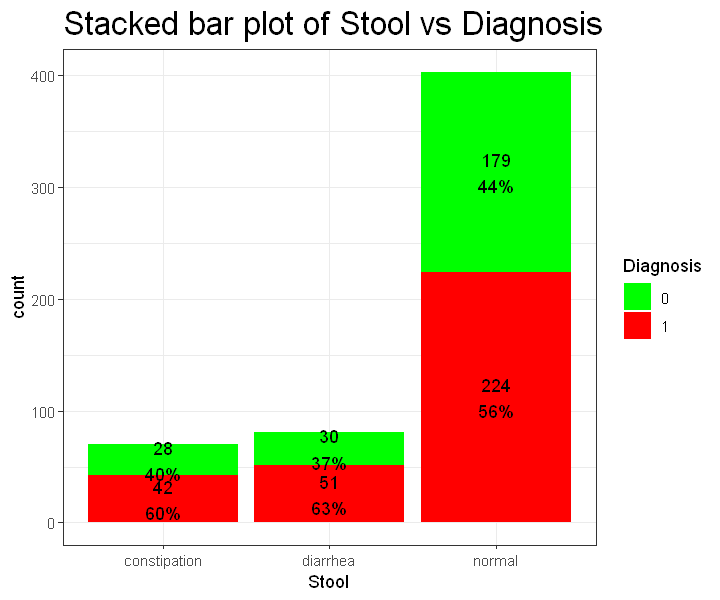

In [18]:
options(repr.plot.width = 6, repr.plot.heigth = 4)

#Stacked bar plot of Stool vs Diagnosis
ggplot(M_plot) +
aes(x=Stool, y = count, fill = Diagnosis, label = percentage) +
geom_col() +
theme_bw() +
scale_fill_manual(values = c("0" = "green", "1" = "red")) +
geom_text(position = position_stack(0.5)) +
labs(title = "Stacked bar plot of Stool vs Diagnosis")+
theme(plot.title = element_text(size=20))

We do not see a great difference in "constipation" and "diarrhea" in terms of the binary values of the target variable so we can merge them together as "not_normal" category. <br>
We observe a limited distinction between the occurrence of "constipation" and "diarrhea" concerning values of Diagnosis(target). Therefore combining these categories into one single category named "not_normal" seems appropriate.

In [19]:
#combine categories of Stool
df <- df %>% 
            mutate(Stool = if_else(Stool != "normal", "not_normal", Stool))

In [20]:
#data points in each category of Peritonitis
table(df$Peritonitis)


generalized       local          no 
         26         129         399 

Since the number of data points for categories "generalized" and "local" are minimal and they both convey that spasm of abdominal wall muscels were detected, we can combine them to one single category names "yes". 
Given the minimal number of data points for both "generalized" and "local" categories, which both indicate the detection of spasms in abdominal wall muscles, combining them into a single category named "yes" seems appropriate."

In [21]:
#combine categories of "Peritonitis"
df <- df %>% 
            mutate(Peritonitis = if_else(Peritonitis != "no", "yes", Peritonitis))

<font size = 6> Feature Selection <font>

Before starting our feature selection let's run a glm on the full model and analyze the result.

In [22]:
#Full model
full_model <-   glm(Diagnosis ~ .,
                data = df,
                family = binomial()
                )

coef(full_model)

(Intercept)                                 Age 
                            3.81401                             0.01823 
                                BMI                             Sexmale 
                           -0.12701                             0.01174 
                             Weight                      Length_of_Stay 
                            0.03310                             0.64057 
                  Appendix_on_USyes                   Migratory_Painyes 
                            3.71510                             0.45502 
            Lower_Right_Abd_Painyes Contralateral_Rebound_Tendernessyes 
                            1.17967                             0.30617 
                   Coughing_Painyes                           Nauseayes 
                            0.68694                             0.68408 
                Loss_of_Appetiteyes                    Body_Temperature 
                           -0.05478                            -0.29936 
                          WBC_Count               Neutrophil_Percentage 
                            0.14257                             0.02952 
                    Neutrophiliayes                           RBC_Count 
                           -0.76135                            -0.27526 
                         Hemoglobin                                 RDW 
                           -0.08625                             0.00138 
                  Thrombocyte_Count                                 CRP 
                            0.00014                             0.01689 
                         Dysuriayes                     Stoolnot_normal 
                           -0.08054                             0.55666 
                     Peritonitisyes                       Psoas_Signyes 
                            1.73255                            -1.02105 
                     Free_Fluidsyes 
                            0.32405

**Information Leakage of predicotrs:** <br>
Magnitude of the "Appendix_on_US" coefficient is different than the other coefficients. <br> 
A normal Appendix is typically small and may be challenging to detect on an ultrasound. <br>
The ability to detect the appendix on the ultrasound increases the likelihood of diagnosing appendicitis. <br>

Therefore **Appendix_on_US** might be leaking information about the target variable and hence is not a suitable predictor. We will remove this column from the model. 

In [23]:
#Drop Appendix_on_US 
df <- df %>% select(-Appendix_on_US)

In [24]:
#build full model again now that we dropped "Appendix_on_US"
full_model <-   glm(Diagnosis ~ .,
                data = df,
                family = binomial()
                )
head(df)

,Age,BMI,Sex,Weight,Length_of_Stay,Migratory_Pain,Lower_Right_Abd_Pain,Contralateral_Rebound_Tenderness,Coughing_Pain,Nausea,⋯,Hemoglobin,RDW,Thrombocyte_Count,CRP,Dysuria,Stool,Peritonitis,Psoas_Sign,Free_Fluids,Diagnosis
,<dbl>,<dbl>,<fct>,<dbl>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<dbl>,<dbl>,<int>,<dbl>,<fct>,<chr>,<chr>,<fct>,<fct>,<fct>
1,13,17,female,37,3,no,yes,yes,no,no,⋯,15,12,254,0,no,normal,no,yes,no,1
2,14,32,male,70,2,yes,yes,yes,no,no,⋯,16,13,151,3,yes,normal,no,yes,no,0
3,14,23,female,62,4,no,yes,yes,no,no,⋯,11,12,300,3,no,not_normal,no,yes,no,0
4,16,21,female,56,3,yes,yes,no,no,yes,⋯,14,13,258,0,yes,normal,no,yes,no,0
5,11,17,female,45,3,no,yes,yes,yes,yes,⋯,13,14,311,0,no,not_normal,no,yes,no,1
6,11,31,male,45,3,yes,yes,yes,yes,yes,⋯,12,13,249,63,no,not_normal,no,yes,no,0


<font size = 5> Train and Test sets <font>

In [25]:
#Partition data into train and test (60/40)
set.seed(22)
train_ind <- sample(1:nrow(df), size = nrow(df)* 0.6, replace = FALSE)

train_set <- df[train_ind, ]
test_set  <- df[-train_ind, ]

<font size = 5> Stepwise Selection <font>

In [26]:
#forward selection
step_forward  <-    MASS::stepAIC(
                        object = full_model,
                        direction = "forward"
                        )

Start:  AIC=570
Diagnosis ~ Age + BMI + Sex + Weight + Length_of_Stay + Migratory_Pain + 
    Lower_Right_Abd_Pain + Contralateral_Rebound_Tenderness + 
    Coughing_Pain + Nausea + Loss_of_Appetite + Body_Temperature + 
    WBC_Count + Neutrophil_Percentage + Neutrophilia + RBC_Count + 
    Hemoglobin + RDW + Thrombocyte_Count + CRP + Dysuria + Stool + 
    Peritonitis + Psoas_Sign + Free_Fluids



In [27]:
#forward-backward selection
step_both  <- MASS::stepAIC(
                object = full_model,
                direction = "both"
                )

Start:  AIC=570
Diagnosis ~ Age + BMI + Sex + Weight + Length_of_Stay + Migratory_Pain + 
    Lower_Right_Abd_Pain + Contralateral_Rebound_Tenderness + 
    Coughing_Pain + Nausea + Loss_of_Appetite + Body_Temperature + 
    WBC_Count + Neutrophil_Percentage + Neutrophilia + RBC_Count + 
    Hemoglobin + RDW + Thrombocyte_Count + CRP + Dysuria + Stool + 
    Peritonitis + Psoas_Sign + Free_Fluids

                                   Df Deviance AIC
- Loss_of_Appetite                  1      518 568
- RDW                               1      518 568
- Hemoglobin                        1      518 568
- Dysuria                           1      519 569
- Thrombocyte_Count                 1      519 569
- Age                               1      519 569
- Weight                            1      519 569
- RBC_Count                         1      519 569
- Nausea                            1      520 570
- Sex                               1      520 570
- Neutrophilia                      1 

Unlike the forward selection, the forward-backward selection dropped some predictors, this could be because the forward-backward can go through ALL the predictors and drop the predictors that do not contribute significantly to the model fit. <br>
Once a predictor is added to the forward selection method, it cannot be dropped in the further steps. Therefore, the result of forward-backard selection method could be more reliable.

In [28]:
#add all AIC scores to comparison dataframe
comparison <-  data.frame(Model = c("full", "forward", "forward-backward"),
                              AIC = c(full_model %>% 
                                      AIC() %>% round(2), 
                                      step_forward %>% 
                                      AIC() %>% round(2), 
                                      step_both %>% 
                                      AIC() %>% round(2)
                                     )
                             )

AIC of forward-backward selection model is the lowest. The full model and forward model all identical because nothing was dropped after forward selection method.

The forward-backward selection reduced the number of predictors from 25 to 13.

In [29]:
#Prediction using full model on test data
predict_test_full <- factor(predict(object = full_model,
                         newdata = test_set,
                         type = "response") 
                 %>%
                 round())

#Prediction using forward selection model on test data
predict_test_forward <- factor(predict(object = step_forward,
                         newdata = test_set,
                         type = "response") 
                 %>%
                 round())


#Prediction using forward-backward selection model on test data
predict_test_both <- factor(predict(object = step_both,
                         newdata = test_set,
                         type = "response") 
                 %>%
                 round())


#reference values
actual_values <- test_set$Diagnosis

#create confusion matrix for each prediction and extract the accuracy value
cm_full <- confusionMatrix(
                           predict_test_full, 
                           reference = actual_values
                          )$overall["Accuracy"][[1]] %>% round(2)

cm_forward <- confusionMatrix(
                             predict_test_forward, 
                             reference = actual_values
                             )$overall["Accuracy"][[1]] %>% round(2)

cm_both <- confusionMatrix(
                           predict_test_both, 
                           reference = actual_values
                           )$overall["Accuracy"][[1]] %>% round(2)

comparison <-   comparison %>%
                               mutate(Accuracy = c(cm_full, cm_forward, cm_both))
comparison

Model,AIC,Accuracy
<chr>,<dbl>,<dbl>
full,570,0.77
forward,570,0.77
forward-backward,557,0.75


We ran all three models (full model, forward method final model, and forward-backward method final model). <br>
Although the forward-backward model has the best AIC, its accuracy is not the largest. The AIC score of forward-backward is better than the other ones because of the penalty factor for number of predictors. <br>

<font size = 5> Selected Features: <font>

In [30]:
#Names of the features selected by forward-backward selection method
names(coefficients(step_both))[-1] 

[1] "BMI"                                 "Weight"                             
 [3] "Length_of_Stay"                      "Migratory_Painyes"                  
 [5] "Lower_Right_Abd_Painyes"             "Contralateral_Rebound_Tendernessyes"
 [7] "Coughing_Painyes"                    "Body_Temperature"                   
 [9] "WBC_Count"                           "Neutrophil_Percentage"              
[11] "CRP"                                 "Peritonitisyes"                     
[13] "Psoas_Signyes"

In [31]:
selected_features <- c('BMI','Weight','Length_of_Stay','Migratory_Pain','Lower_Right_Abd_Pain',
                       'Contralateral_Rebound_Tenderness','Coughing_Pain','Body_Temperature',
                       'WBC_Count','Neutrophil_Percentage','CRP','Peritonitis','Psoas_Sign')

#The dataset after feature selection
fs_df <- df %>% select(all_of(selected_features), Diagnosis)
head(fs_df)

,BMI,Weight,Length_of_Stay,Migratory_Pain,Lower_Right_Abd_Pain,Contralateral_Rebound_Tenderness,Coughing_Pain,Body_Temperature,WBC_Count,Neutrophil_Percentage,CRP,Peritonitis,Psoas_Sign,Diagnosis
,<dbl>,<dbl>,<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>,<fct>
1,17,37,3,no,yes,yes,no,37,7.7,68,0,no,yes,1
2,32,70,2,yes,yes,yes,no,37,8.1,65,3,no,yes,0
3,23,62,4,no,yes,yes,no,37,13.2,75,3,no,yes,0
4,21,56,3,yes,yes,no,no,36,11.4,63,0,no,yes,0
5,17,45,3,no,yes,yes,yes,37,8.1,44,0,no,yes,1
6,31,45,3,yes,yes,yes,yes,37,9.5,71,63,no,yes,0


<font size =5> Train and test sets using only selected features <font>

In [32]:
#Partition data into train and test (60/40)
train_set <- fs_df[train_ind, ]
test_set  <- fs_df[-train_ind, ]

<font size =5 > Interactions between the selected features? <font>

Since our target value is binary, we cannot easily detect the possibility of any interaction from the scatterplot. <br>
Also having the field knowledge would have helped us better understand the relationship between different predictors. <br>
We can add the interaction between two pairs of categorical-numerical predictors and check to see if the forward-backward selection would drop those from the model.

In [33]:
#fit the full model with the interaction between (Neutrophil_Percentage and Psoas_Sign) and (WBC_Count and Migratory_Pain)
full_model_fs <- glm(Diagnosis ~. +Neutrophil_Percentage:Psoas_Sign + WBC_Count:Migratory_Pain,
                     data = train_set,
                     family = binomial()
                     )
#forward-backward selection on the full model
step_both  <- MASS::stepAIC(
                object = full_model_fs,
                direction = "both"
                )

Start:  AIC=333
Diagnosis ~ BMI + Weight + Length_of_Stay + Migratory_Pain + 
    Lower_Right_Abd_Pain + Contralateral_Rebound_Tenderness + 
    Coughing_Pain + Body_Temperature + WBC_Count + Neutrophil_Percentage + 
    CRP + Peritonitis + Psoas_Sign + Neutrophil_Percentage:Psoas_Sign + 
    WBC_Count:Migratory_Pain

                                   Df Deviance AIC
- Body_Temperature                  1      302 332
- Lower_Right_Abd_Pain              1      302 332
- Migratory_Pain:WBC_Count          1      302 332
- Neutrophil_Percentage:Psoas_Sign  1      302 332
- Contralateral_Rebound_Tenderness  1      303 333
- CRP                               1      303 333
<none>                                     301 333
- Coughing_Pain                     1      305 335
- Peritonitis                       1      305 335
- Weight                            1      306 336
- BMI                               1      308 338
- Length_of_Stay                    1      344 374

Step:  AIC=332
D

We can see that forward-backward selection dropped the interaction terms for both pairs and did not consider them significant for the fit of the model. <br>
Therefore we will not consider them for our model.

<font size =5> Confusion matrices for different thresholds using selected features from stepwise selection method<font>

<font size =5> Prediction of test set <font>

In [34]:
#Fit full model using selected features
full_model_fs <- glm(Diagnosis ~.,
                     data = fs_df,
                     family = binomial()
                     )

#predict probabilities of test set
pred_prob_fs <- predict(full_model_fs,
                       newdata = test_set, 
                       type = "response")


<font size = 5> Threshold = 0.5 <font>

In [35]:
#Threshold = 0.5 for classification
threshold <- 0.5

#Predict classes and convert to factors
pred_class_fs <- if_else(pred_prob_fs>threshold, 1, 0) %>% as.factor()
confusionMatrix(pred_class_fs, reference = test_set$Diagnosis)

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 70 32
         1 24 96
                                        
               Accuracy : 0.748         
                 95% CI : (0.685, 0.803)
    No Information Rate : 0.577         
    P-Value [Acc > NIR] : 0.00000008    
                                        
                  Kappa : 0.489         
                                        
 Mcnemar's Test P-Value : 0.35          
                                        
            Sensitivity : 0.745         
            Specificity : 0.750         
         Pos Pred Value : 0.686         
         Neg Pred Value : 0.800         
             Prevalence : 0.423         
         Detection Rate : 0.315         
   Detection Prevalence : 0.459         
      Balanced Accuracy : 0.747         
                                        
       'Positive' Class : 0             
                                        

<font size = 5> Threshold = 0.55 <font>

In [36]:
#Threshold = 0.55 for classification
threshold <- 0.55

#Predict classes and convert to factors
pred_class_fs <- if_else(pred_prob_fs>threshold, 1, 0) %>% as.factor()
cm <- confusionMatrix(pred_class_fs, reference = test_set$Diagnosis)
cm_both_0.55 <- cm$overall["Accuracy"][[1]] %>% round(2)
cm

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 78 36
         1 16 92
                                       
               Accuracy : 0.766        
                 95% CI : (0.704, 0.82)
    No Information Rate : 0.577        
    P-Value [Acc > NIR] : 0.0000000028 
                                       
                  Kappa : 0.533        
                                       
 Mcnemar's Test P-Value : 0.00842      
                                       
            Sensitivity : 0.830        
            Specificity : 0.719        
         Pos Pred Value : 0.684        
         Neg Pred Value : 0.852        
             Prevalence : 0.423        
         Detection Rate : 0.351        
   Detection Prevalence : 0.514        
      Balanced Accuracy : 0.774        
                                       
       'Positive' Class : 0            
                                       

In diagnosing appendicitis, both sensitivity and specificity are important, but their relative importance depends on various factors, including the consequences of false positives and false negatives. <br>

**High sensitivity** is usually prioritized to ensure that the test can effectively **detect patients who have appendicitis** and high specificity helps minimize unnecessary surgeries or treatments. Since this test would not be the only test for detecting the disease, we would prefer to have a higher sensitivity rather than having a higher specificity.
 **Threshold of 0.55** is maintaining an **optimal balance between sensitivity and specificity**.

<font size = 6> Ridge and Lasso <font>

**Ridge Regression:**

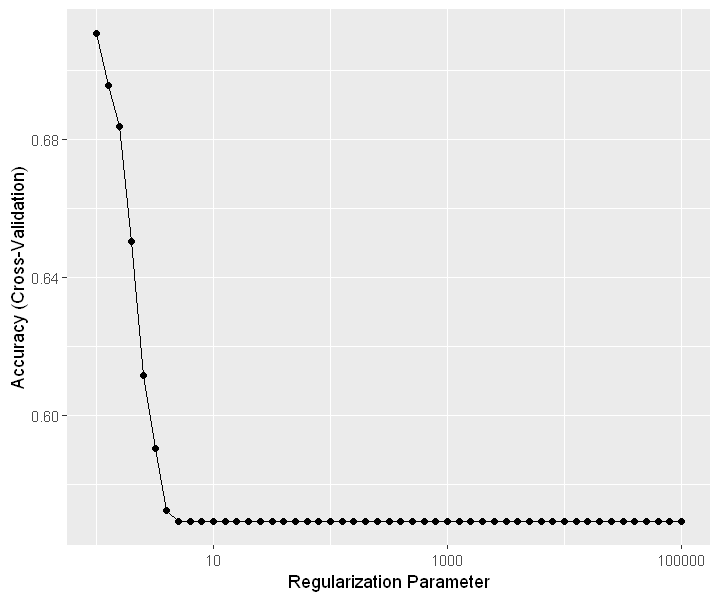

In [37]:
set.seed(22)

#Set up the control parameter for cross validation-process with 5 folds
trControl <- caret::trainControl(method = "cv", number = 5, allowParallel = TRUE)

#Create a grid of tunning parameter for Ridge model
tuneGrid <- expand.grid(lambda = 10^seq(5, 0, by=-0.1), alpha =0)
ridge_model <- caret::train(Diagnosis ~.,
                      data = train_set,
                      method = "glmnet",
                      family = "binomial",
                      trControl = trControl,
                      tuneGrid=tuneGrid)

#visualize the cross-validation accuracy value as a function of the tuning parameter 
ggplot(ridge_model) +scale_x_log10()

In [38]:
#The best tunning parameters selected during cross-validation
ridge_model$bestTune

#Coefficients of the final LASSO model using best Lambda value
coef(ridge_model$finalModel, s=ridge_model$bestTune$lambda)

,alpha,lambda
,<dbl>,<dbl>
1,0,1


14 x 1 sparse Matrix of class "dgCMatrix"
                                          s1
(Intercept)                         -2.81168
BMI                                 -0.00900
Weight                              -0.00079
Length_of_Stay                       0.04693
Migratory_Painyes                    0.09257
Lower_Right_Abd_Painyes              0.14061
Contralateral_Rebound_Tendernessyes  0.11335
Coughing_Painyes                     0.08645
Body_Temperature                     0.05409
WBC_Count                            0.01849
Neutrophil_Percentage                0.00810
CRP                                  0.00178
Peritonitisyes                       0.21018
Psoas_Signyes                       -0.13852

In [39]:
#Make predictions on the test set
predict_test_ridge <- predict(ridge_model, test_set) %>% as.factor()

cm_ridge <-    confusionMatrix(
                                 predict_test_ridge, 
                                 reference = test_set$Diagnosis
                                 )$overall["Accuracy"][[1]] %>% round(2)

**LASSO Regression**

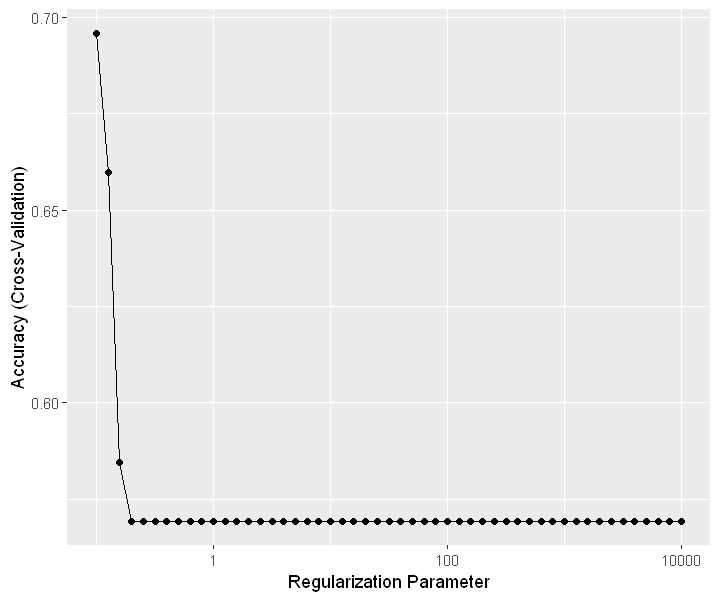

In [40]:
set.seed(22)

#Create a grid of tunning parameter for Lasso model
tuneGrid <- expand.grid(lambda = 10^seq(4, -1, by=-0.1), alpha = 1)
lasso_model <- caret::train(Diagnosis ~.,
                      data = train_set,
                      method = "glmnet",
                      family = "binomial",
                      trControl = trControl,
                      tuneGrid=tuneGrid)

#visualize the cross-validation accuracy value as a function of the tuning parameter 
ggplot(lasso_model) +scale_x_log10()

In [41]:
#The best tunning parameters selected during cross-validation
lasso_model$bestTune

#Coefficients of the final LASSO model using best Lambda value
lasso_finalModel <- lasso_model$finalModel
coef(lasso_finalModel, s=lasso_model$bestTune$lambda)

,alpha,lambda
,<dbl>,<dbl>
1,1,0.1


14 x 1 sparse Matrix of class "dgCMatrix"
                                        s1
(Intercept)                         -1.725
BMI                                  .    
Weight                               .    
Length_of_Stay                       0.125
Migratory_Painyes                    .    
Lower_Right_Abd_Painyes              .    
Contralateral_Rebound_Tendernessyes  .    
Coughing_Painyes                     .    
Body_Temperature                     .    
WBC_Count                            .    
Neutrophil_Percentage                0.021
CRP                                  .    
Peritonitisyes                       0.103
Psoas_Signyes                        .    

In [42]:
#Make predictions on the test set
predict_test_lasso <- predict(lasso_model, test_set) %>% as.factor()

cm_lasso <-    confusionMatrix(
                                 predict_test_lasso, 
                                 reference = test_set$Diagnosis
                                 )$overall["Accuracy"][[1]] %>% round(2)

<font size = 6> PCA for numerical variables <font>

We would like to run PCA on the numerical columns of our cleaned data and then merge the pca components to the categorical columns and fit the logistic model.

In [43]:
numeric_colnames  <-    df %>% 
                        select(where(is.numeric)) %>%
                        colnames()

In [44]:
#PCA without normalizing
pcs <- prcomp(df[,numeric_colnames], scale = FALSE)
 summary(pcs)

Importance of components:
                          PC1    PC2    PC3     PC4     PC5     PC6     PC7
Standard deviation     67.635 50.594 17.757 13.7666 5.13597 3.47645 2.67663
Proportion of Variance  0.595  0.333  0.041  0.0246 0.00343 0.00157 0.00093
Cumulative Proportion   0.595  0.927  0.968  0.9930 0.99642 0.99799 0.99892
                           PC8    PC9    PC10    PC11    PC12
Standard deviation     2.05707 1.5201 1.05131 0.70061 0.42501
Proportion of Variance 0.00055 0.0003 0.00014 0.00006 0.00002
Cumulative Proportion  0.99947 0.9998 0.99991 0.99998 1.00000

Without normalizing the data, largest values will dominate the principal components.
Similar to what we observe from results above that only the first two components account for more than 92% of total variability.

In [45]:
#PCA with normalized data
pcs <- prcomp(df[,numeric_colnames], scale = TRUE)
summary(pcs)
pcs$rotation[,1:8]

Importance of components:
                         PC1   PC2   PC3    PC4    PC5    PC6    PC7    PC8
Standard deviation     1.783 1.406 1.194 1.0437 1.0246 0.9411 0.8640 0.6932
Proportion of Variance 0.265 0.165 0.119 0.0908 0.0875 0.0738 0.0622 0.0401
Cumulative Proportion  0.265 0.430 0.548 0.6391 0.7266 0.8004 0.8627 0.9027
                          PC9   PC10   PC11    PC12
Standard deviation     0.6849 0.6072 0.5167 0.25066
Proportion of Variance 0.0391 0.0307 0.0222 0.00524
Cumulative Proportion  0.9418 0.9725 0.9948 1.00000

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
Age,-0.406,-0.282,0.082,0.061,0.143,0.195,-0.2084,0.34768
BMI,-0.354,-0.345,0.221,-0.302,-0.053,-0.170,0.2964,-0.31412
Weight,-0.430,-0.387,0.160,-0.157,0.060,-0.025,0.1070,-0.05053
Length_of_Stay,0.210,-0.354,0.216,0.206,-0.094,-0.426,-0.5082,0.11047
Body_Temperature,0.299,-0.181,-0.036,0.144,0.348,-0.228,0.6996,0.32285
WBC_Count,0.337,-0.363,-0.106,-0.321,0.107,0.284,-0.1522,0.00028
Neutrophil_Percentage,0.314,-0.345,-0.152,-0.148,0.289,0.432,-0.0783,-0.22288
RBC_Count,-0.084,-0.121,-0.687,0.040,-0.241,-0.222,0.0438,-0.44389
Hemoglobin,-0.240,-0.221,-0.577,0.136,0.014,-0.052,-0.0708,0.48419
RDW,0.062,-0.186,0.101,0.246,-0.724,0.482,0.2690,0.14875


Interesting to see that after scaling the data we need the **first 8 components** to **account for 90% of total variability**. <br>
1st component captures Age and Weight. <br>
2nd component captures CRP, Weight and WBC_Count. <br>
3rd component is about blood characteristics such as RBC_Count and Hemoglobin. <br>
the first 4 components account for 64% of total variability, and the first 5 components account for 73%. <br>
This relatively big jump shows that the **RDW** is explaining the total variability very well. 

Instead of 12 numerical predictors PCA gave us 8 components to use along with categorical predictors.

In [46]:
categorical_df <- df %>% select(!all_of(numeric_colnames))
PCA_combined_data <- cbind(pcs$x[,1:9], categorical_df)

<font size = 5> Train and Test set for PCA combined data <font>

In [47]:
#Partition data into train and test (60/40)
train_set_pca <- PCA_combined_data[train_ind, ]
test_set_pca  <- PCA_combined_data[-train_ind, ]

In [48]:
#fit logistic regression model on the combined pca data
PCA_model <-   glm(Diagnosis ~ . ,
                    data = train_set_pca,
                    family = binomial()
                    )

In [49]:
#make predictions on the test set
pca_pred_probabilities <- predict(PCA_model,
                            newdata = test_set_pca[,-23],
                            type = "response")

#prediction classes
pca_pred_classes <- if_else(
                            pca_pred_probabilities >0.5, 1, 0) %>% 
                            as.factor()

#Confusion matrix for pca model predictions
cm_pca <-    confusionMatrix(
                                 pca_pred_classes, 
                                 reference = test_set_pca$Diagnosis
                                 )$overall["Accuracy"][[1]] %>% round(2)

<font size=6> Final Comparison of the models predicting the test set <font>

In [50]:
#Forward-Backward, RIDGE, LASSO, PCA
final_comparison <- data.frame(model = c("Forward-Backward", "Forward-Backward-0.55", "Ridge", "Lasso", "PCA"),
                               Threshold = c(0.5, 0.55, 0.5, 0.5, 0.5),
                               Accuracy = c(cm_both, cm_both_0.55, cm_ridge, cm_lasso, cm_pca)) %>%
                              arrange(desc(Accuracy))
final_comparison

model,Threshold,Accuracy
<chr>,<dbl>,<dbl>
Forward-Backward-0.55,0.55,0.77
Forward-Backward,0.50,0.75
PCA,0.50,0.74
Ridge,0.50,0.70
Lasso,0.50,0.67


Looking at the results, the forward-backward feature selection has done a good job finding the most significant predictors for our model. <br>
However, Ridge and Lasso did not do very well on the accuracy. This could be because of the penalizing factors. <br>
Also PCA was able to fit a good model using the first 8 components which where linear combinations of the numerical predictors. <br>
By setting the threshold to 0.55 we got a better acuuracy, higher sensitivity and lower specificity for our forward-backward feature selection model.

<font size = 6> ROC <font>

**Comparison of ROC curves for different models**

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



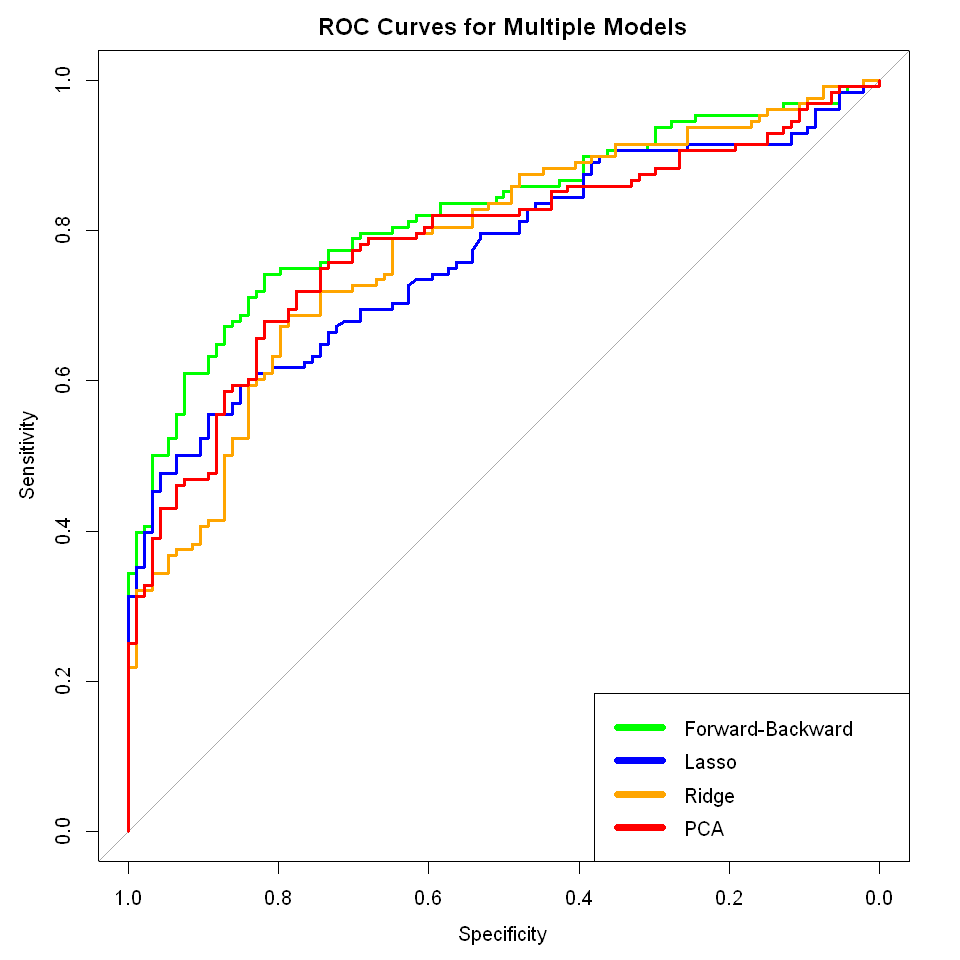

In [51]:
options(repr.plot.width = 8, repr.plot.height = 8)

plot(roc(test_set$Diagnosis, pred_prob_fs), main = "ROC Curves for Multiple Models", col = "green", lwd = 3)
plot(roc(test_set$Diagnosis, predict(lasso_model, test_set, type = "prob")[[2]]), col = "blue", lwd = 3, add=TRUE)
plot(roc(test_set$Diagnosis, predict(ridge_model, test_set, type = "prob")[[2]]), col = "orange", lwd = 3, add=TRUE)
plot(roc(test_set$Diagnosis,as.numeric(pca_pred_probabilities)), col = "red", lwd = 3, add=TRUE)
legend("bottomright", 
       legend = c("Forward-Backward", "Lasso", "Ridge", "PCA"), 
       col = c("green", "blue", "orange", "red"), 
       lty = 1, 
       cex = 1,
      lwd = 6)

<font size = 6> Conclusion <font>

**Forward-backward feature selection model** stands out for its ability to identify the most significant predictors for our model. <br>

**PCA** was able to fit a good model using the first 8 components derived from linear combinations of our numerical predictors. However it lacks the interpretability factor. In contexts such as clinical applications, where understanding the individual impact of predictors is crucial for decision-making, this lack of interpretability could be a significant limitation.

**Ridge** and **Lasso** models did not have better performances compared to forward-backward and PCA models.

Comparing the ROC curves of different models, for a given specificity above 0.6, forward-backward feature selection model sensitivity is greater. <br>

Considering the balance between **performance** and **interpretability**, the **forward-backward feature selection model** is the preferred model.